# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import datetime
import pickle
import matplotlib.pyplot as plt


In [2]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split
from surprise import dump





In [3]:
# read in the cleaned completed offers data set
completed_offers = pd.read_csv('./data/cleaned_completed_offers.csv', parse_dates=['member_on'])

In [4]:
completed_offers.shape

(150435, 22)

In [5]:
# select one user and explore the transcript records
completed_offers[completed_offers['person']=='78afa995795e4d85b5d9ceeca43f5fef'].sort_values('time')

,person,offer_id,time,time_received,time_viewed,time_completed,time_transaction,amount,reward,pot_reward,...,offer_type,web,email,mobile,social,gender,age,income,member_on,info
69987,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,6.0,132.0,132.0,19.89,5.0,5.0,...,bogo,1.0,1.0,1.0,0.0,F,75.0,100000.0,2017-05-09,NaN
69988,78afa995795e4d85b5d9ceeca43f5fef,NaN,144.0,NaN,NaN,NaN,144.0,17.78,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN
69989,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,168.0,168.0,216.0,222.0,222.0,19.67,NaN,0.0,...,informational,0.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09,1.0
69990,78afa995795e4d85b5d9ceeca43f5fef,NaN,222.0,NaN,NaN,NaN,222.0,19.67,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN
69991,78afa995795e4d85b5d9ceeca43f5fef,NaN,240.0,NaN,NaN,NaN,240.0,29.72,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN
69992,78afa995795e4d85b5d9ceeca43f5fef,NaN,378.0,NaN,NaN,NaN,378.0,23.93,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN
69993,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,408.0,408.0,408.0,510.0,510.0,21.72,10.0,10.0,...,bogo,0.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09,NaN
69994,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,504.0,504.0,582.0,NaN,NaN,NaN,NaN,5.0,...,bogo,1.0,1.0,1.0,1.0,F,75.0,100000.0,2017-05-09,NaN
69995,78afa995795e4d85b5d9ceeca43f5fef,NaN,534.0,NaN,NaN,NaN,534.0,26.56,NaN,NaN,...,transaction,NaN,NaN,NaN,NaN,F,75.0,100000.0,2017-05-09,NaN


### Cleaned completed offers set

- Now we have a cleaned completed offers set that we can use to build our recommendation engine.
- We will build User based collaborative filtering, however that will have a Cold Start Problem
- To address cold Start problem we will come up with rank based recommendations.

In [6]:
# What is most popular offer ? 

def get_top_popular_offer_ids(n, completed_offers):
    '''
    INPUT:
    n - (int) the number of top offers to return
    df - (pandas dataframe) df  to evaluate
    OUTPUT:
    top_offers - (list) A list of the top 'n' offers
    
    '''
    # Your code here
    
    df = completed_offers.copy()
   # filtering with query method
    lst = ['offer_id','pot_reward','difficulty', 'duration', 'offer_type']
    data = df[lst]
    top_offers_lst = list(data.offer_id.value_counts().head(n).index)
    df_top_offers_all = data[data['offer_id'].isin(top_offers_lst)]
    df_top_offers = df_top_offers_all.drop_duplicates(subset='offer_id', keep='first')
  
    return df_top_offers # Return the top 

get_top_popular_offer_ids(1, completed_offers)


,offer_id,pot_reward,difficulty,duration,offer_type
5,fafdcd668e3743c1bb461111dcafc2a4,2.0,10.0,10.0,discount


Discount Offer of 2 dollars off when you spend 10$ seems to be most popular amoung users. So this would be a good option to present to new users.

Now lets see what is more profitable to  Starbucks


,gain
offer_id,
fafdcd668e3743c1bb461111dcafc2a4,72500.35
2298d6c36e964ae4a3e7e9706d1fb8c2,59843.15
f19421c1d4aa40978ebb69ca19b0e20d,52152.63
2906b810c7d4411798c6938adc9daaa5,39327.55
4d5c57ea9a6940dd891ad53e9dbe8da0,38555.65
ae264e3637204a6fb9bb56bc8210ddfd,35914.94
5a8bc65990b245e5a138643cd4eb9837,32311.90
0b1e1539f2cc45b7b9fa7c272da2e1d7,28342.59
9b98b8c7a33c4b65b9aebfe6a799e6d9,27418.37


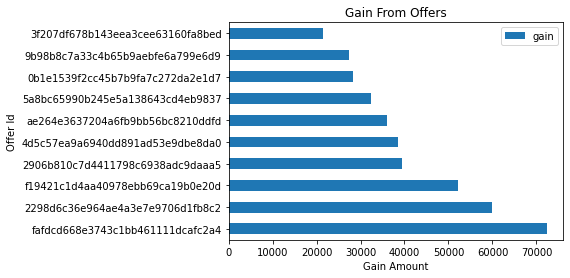

In [7]:
def get_top_gain_offer_ids( completed_offers):
    '''
    INPUT:
    
    completed_offers - (pandas dataframe) df  to evaluate
    OUTPUT:
    top_offers - (list) A list of the top offers with best gain
    
    '''
    
    df = completed_offers.copy()
    # using apply function to create a new column 
    df['gain'] = df.apply(lambda row: row.amount - 
                                  row.pot_reward, axis = 1)

    
    sum_gain = df.groupby(['offer_id']).agg({'gain': 'sum'})

    sum_gain.sort_values('gain', ascending=False, inplace=True)
    
    gain_chart = sum_gain.plot(kind='barh', title='Gain From Offers')
    gain_chart.set_ylabel('Offer Id')
    gain_chart.set_xlabel('Gain Amount')
    
    return sum_gain # Return the top 

get_top_gain_offer_ids( completed_offers)


fafdcd668e3743c1bb461111dcafc2a4 is winner here as well. It is popular with users and also gives most gain to the company.  So this would definitely be a good option to present to new users by default.

Now lets build recommendation system which is based on similar user preferencces.  

In [8]:
def create_user_conversion_df(data):
    df = data.groupby(['person','offer_id'])['time_completed'].agg(['count']).reset_index()
    
    df = df.rename({'count':'estimator', 'offer_id':'offerId'}, axis=1)
    return df
user_conversions_df = create_user_conversion_df(completed_offers)
user_conversions_df.head()

,person,offerId,estimator
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0
4,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1


In [9]:
# select one user and explore the transcript records
user_conversions_df[user_conversions_df['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,person,offerId,estimator
19833,78afa995795e4d85b5d9ceeca43f5fef,5a8bc65990b245e5a138643cd4eb9837,1
19834,78afa995795e4d85b5d9ceeca43f5fef,9b98b8c7a33c4b65b9aebfe6a799e6d9,1
19835,78afa995795e4d85b5d9ceeca43f5fef,ae264e3637204a6fb9bb56bc8210ddfd,1
19836,78afa995795e4d85b5d9ceeca43f5fef,f19421c1d4aa40978ebb69ca19b0e20d,0


We will use Surprise  which  is an easy-to-use Python scikit for recommender systems. 

In [10]:
from surprise import NormalPredictor, Reader, Dataset, accuracy, SVD, SVDpp, KNNBasic, CoClustering, SlopeOne
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split

def surprise_df(data):
    """Returns a user conversion matrix with users incorporated as the index and each offer olist
    offers as a unique column.
    Args:
    data -- a dataframe containing user id, offer id, and conversions columns in that order.
    """

    scale = (data.estimator.min(), data.estimator.max())
    reader = Reader(rating_scale=scale)

    # The columns must correspond to user id, offer id and conversions (in that order).
    user_conversion_matrix = Dataset.load_from_df(data[['person',
                                                     'offerId',
                                                     'estimator']], reader)

    return user_conversion_matrix


user_conversion_matrix = surprise_df(user_conversions_df)
train_set, test_set = train_test_split(user_conversion_matrix, test_size=0.2, random_state=19)

Find which alogrithm gives lowest RMSE

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=19)
def model_framework(train_data):
    #store the rmse values for each fold in the k-fold loop 
    normp_rmse, svd_rmse, knn_rmse, co_rmse, slope_rmse = [],[],[], [],[]

    for trainset, testset in kf.split(train_data):
        
        #baseline
        normp = NormalPredictor()
        normp.fit(trainset)
        normp_pred = normp.test(testset)
        normp_rmse.append(accuracy.rmse(normp_pred,verbose=False))
        
        #svd
        svd = SVD(n_factors=30, n_epochs=50,biased=True, lr_all=0.005, reg_all=0.4, verbose=False)
        svd.fit(trainset)
        svd_pred = svd.test(testset)
        svd_rmse.append(accuracy.rmse(svd_pred,verbose=False))
        
        #knn
        knn = KNNBasic(k=40,sim_options={'name': 'cosine', 'user_based': False}, verbose=False) 
        knn.fit(trainset)
        knn_pred = knn.test(testset)
        knn_rmse.append(accuracy.rmse(knn_pred,verbose=False))
        
        #co_clustering
        co = CoClustering(n_cltr_u=3,n_cltr_i=3,n_epochs=20)         
        co.fit(trainset)
        co_pred = co.test(testset)
        co_rmse.append(accuracy.rmse(co_pred,verbose=False))

    
    mean_rmses = [np.mean(normp_rmse),
                  np.mean(svd_rmse),
                  np.mean(knn_rmse),
                  np.mean(co_rmse)
                 ]
    
    model_names = ['baseline','svd','knn','coclustering']
    compare_df = pd.DataFrame(mean_rmses, columns=['RMSE'], index=model_names)
    
    return compare_df
comparison_df = model_framework(user_conversion_matrix)
comparison_df.head()

,RMSE
baseline,0.803452
svd,0.580383
knn,0.697594
coclustering,0.696131


SVD has lowest RMSE. We can use that.

In [12]:
# Lets see if we can improve with GridSearch

def gridsearch(data, model, param_grid):
    param_grid = param_grid
    gs = GridSearchCV(model, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
    gs.fit(data)
    
    new_params = gs.best_params['rmse']
    best_score = gs.best_score['rmse']
    
    print("Best score:", best_score)
    print("Best params:", new_params)
    
    return new_params, best_score
svd_param_grid = {'n_factors': [25, 50],
                  'n_epochs': [30,50],       
                  'lr_all': [0.002,0.005,0.01],
                  'reg_all':[0.02,0.1, 0.4]}

svd_params, svd_score = gridsearch(user_conversion_matrix, SVD, svd_param_grid)

Best score: 0.579935805819865
Best params: {'n_factors': 25, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


In [13]:

def final_model(train_set, test_set):
    params = {'n_factors': 25, 'n_epochs': 30, 'lr_all': 0.005, 
              'reg_all': 0.1} 
    
    svdpp = SVDpp(n_factors=params['n_factors'], 
                    n_epochs=params['n_epochs'],
                    lr_all=params['lr_all'], 
                    reg_all=params['reg_all'])
    svdpp.fit(train_set)
    
    predictions = svdpp.test(test_set)
    rmse = accuracy.rmse(predictions,verbose=False)
    # Use surprise wrapper to pickle model
   
    dump.dump('repeat_customer_model', predictions=predictions, algo=svdpp, verbose=0)
    return predictions, rmse, svdpp
    
final_predictions, model_rmse, model_svdpp  = final_model(train_set, test_set)

In [14]:
model_rmse

0.5753265178951623

In addition to looking at the model_rmse output from our final, trained model, we will look at the distribution of the absolute errors across all predictions. To do this, we will package the predictions output into a dataframe and add on a column that indicates error for each prediction. 
We will then visualize the results by plotting a histogram of the errors.

In [15]:
results = pd.DataFrame(final_predictions, columns=['userid', 'item_id', 'user_rating', 'model_est', 'details'])     
results['err'] = abs(results.model_est - results.user_rating)

Text(0, 0.5, 'Frequency')

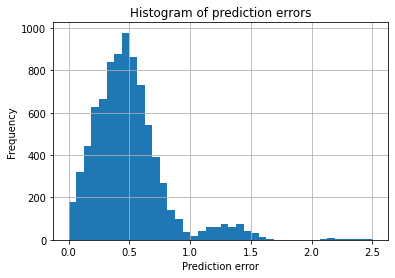

In [16]:
results['err'].hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('Prediction error')
plt.ylabel('Frequency')

In [12]:
#run this cell if you want to load the saved model
#final_predictions, model_svdpp = dump.load('repeat_customer_model')
#results = pd.DataFrame(final_predictions, columns=['userid', 'item_id', 'user_rating', 'model_est', 'details'])     
#results['err'] = abs(results.model_est - results.user_rating)

Ask the engine which offers are recommended for a particular user.

In [17]:
def recommend_offer(user,offers):
    recommend = {}
    
    for single_offer in offers:
         my_pred = model_svdpp.predict(user, single_offer )
         recommend[single_offer] = my_pred.est
         
    
    print("Best offers to give to user : {} are :".format(user))
    for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
              print("offer id: ", offer_id, " predicted value: ", round(pred_val,2))



In [18]:
completed_offers_new = completed_offers[completed_offers['offer_id'].notna()]
offers = completed_offers_new.offer_id.unique()


In [19]:
recommend_offer('42c58541871e4062bfc7c30f7fa266d5',offers)

Best offers to give to user : 42c58541871e4062bfc7c30f7fa266d5 are :
offer id:  fafdcd668e3743c1bb461111dcafc2a4  predicted value:  0.9
offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2  predicted value:  0.86
offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9  predicted value:  0.76
offer id:  2906b810c7d4411798c6938adc9daaa5  predicted value:  0.75
offer id:  f19421c1d4aa40978ebb69ca19b0e20d  predicted value:  0.73
offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7  predicted value:  0.72
offer id:  5a8bc65990b245e5a138643cd4eb9837  predicted value:  0.64
offer id:  ae264e3637204a6fb9bb56bc8210ddfd  predicted value:  0.61
offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0  predicted value:  0.61
offer id:  3f207df678b143eea3cee63160fa8bed  predicted value:  0.51


Conclusion : For new users we can provide the most popular offers or the offer that makes most gain for Starbucks. For others we can use recommender model.